In [1]:
# Ignore Warnings
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")

# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import re
import time
import warnings
from tqdm import tqdm
import datetime as dt
import pandas_datareader as web
from datetime import datetime
import scipy.stats as stats
from pathlib import Path

# ML/DL imports
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Allows us to see more information regarding the DataFrame
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [2]:
url = 'https://www.cryptodatadownload.com/cdd/Gemini_ETHUSD_1h.csv'
dataset = pd.read_csv(url, index_col="date", skiprows=1)
#dataset = pd.read_csv('Gemini_ETHUSD_1h.csv', index_col="date", skiprows=1)
dataset.head()

,unix,symbol,open,high,low,close,Volume ETH,Volume USD
date,,,,,,,,
2022-08-25 00:00:00,1661385600000,ETH/USD,1656.40,1672.51,1655.12,1669.66,400.576414,6.688264e+05
2022-08-24 23:00:00,1661382000000,ETH/USD,1661.01,1668.55,1651.59,1656.40,265.951014,4.405213e+05
2022-08-24 22:00:00,1661378400000,ETH/USD,1670.70,1677.74,1657.51,1661.01,898.363296,1.492190e+06
2022-08-24 21:00:00,1661374800000,ETH/USD,1684.93,1685.92,1669.94,1670.70,775.933763,1.296353e+06
2022-08-24 20:00:00,1661371200000,ETH/USD,1678.45,1686.46,1678.45,1684.93,127.979835,2.156371e+05


In [3]:
dataset = dataset.iloc[::-1]

dataset.head()



,unix,symbol,open,high,low,close,Volume ETH,Volume USD
date,,,,,,,,
2016-05-09 13:00:00,1462798800,ETH/USD,0.00,12.00,0.00,9.55,432.562115,4130.968200
2016-05-09 14:00:00,1462802400,ETH/USD,9.55,10.00,9.55,10.00,235.774075,2357.740748
2016-05-09 15:00:00,1462806000,ETH/USD,10.00,10.00,9.99,9.99,10.973567,109.625935
2016-05-09 16:00:00,1462809600,ETH/USD,9.99,9.99,9.79,9.83,62.379450,613.189994
2016-05-09 17:00:00,1462813200,ETH/USD,9.83,9.83,9.48,9.49,329.553213,3127.459991


In [4]:
df = dataset.reset_index()
df

,date,unix,symbol,open,high,low,close,Volume ETH,Volume USD
0,2016-05-09 13:00:00,1462798800,ETH/USD,0.00,12.00,0.00,9.55,432.562115,4.130968e+03
1,2016-05-09 14:00:00,1462802400,ETH/USD,9.55,10.00,9.55,10.00,235.774075,2.357741e+03
2,2016-05-09 15:00:00,1462806000,ETH/USD,10.00,10.00,9.99,9.99,10.973567,1.096259e+02
3,2016-05-09 16:00:00,1462809600,ETH/USD,9.99,9.99,9.79,9.83,62.379450,6.131900e+02
4,2016-05-09 17:00:00,1462813200,ETH/USD,9.83,9.83,9.48,9.49,329.553213,3.127460e+03
...,...,...,...,...,...,...,...,...,...
55156,2022-08-24 20:00:00,1661371200000,ETH/USD,1678.45,1686.46,1678.45,1684.93,127.979835,2.156371e+05
55157,2022-08-24 21:00:00,1661374800000,ETH/USD,1684.93,1685.92,1669.94,1670.70,775.933763,1.296353e+06
55158,2022-08-24 22:00:00,1661378400000,ETH/USD,1670.70,1677.74,1657.51,1661.01,898.363296,1.492190e+06
55159,2022-08-24 23:00:00,1661382000000,ETH/USD,1661.01,1668.55,1651.59,1656.40,265.951014,4.405213e+05


In [5]:
#plt.figure(figsize=(12,6))
#sns.lineplot(x='date', y='close', data=df).set_title("Price of Bitcoin")
df

,date,unix,symbol,open,high,low,close,Volume ETH,Volume USD
0,2016-05-09 13:00:00,1462798800,ETH/USD,0.00,12.00,0.00,9.55,432.562115,4.130968e+03
1,2016-05-09 14:00:00,1462802400,ETH/USD,9.55,10.00,9.55,10.00,235.774075,2.357741e+03
2,2016-05-09 15:00:00,1462806000,ETH/USD,10.00,10.00,9.99,9.99,10.973567,1.096259e+02
3,2016-05-09 16:00:00,1462809600,ETH/USD,9.99,9.99,9.79,9.83,62.379450,6.131900e+02
4,2016-05-09 17:00:00,1462813200,ETH/USD,9.83,9.83,9.48,9.49,329.553213,3.127460e+03
...,...,...,...,...,...,...,...,...,...
55156,2022-08-24 20:00:00,1661371200000,ETH/USD,1678.45,1686.46,1678.45,1684.93,127.979835,2.156371e+05
55157,2022-08-24 21:00:00,1661374800000,ETH/USD,1684.93,1685.92,1669.94,1670.70,775.933763,1.296353e+06
55158,2022-08-24 22:00:00,1661378400000,ETH/USD,1670.70,1677.74,1657.51,1661.01,898.363296,1.492190e+06
55159,2022-08-24 23:00:00,1661382000000,ETH/USD,1661.01,1668.55,1651.59,1656.40,265.951014,4.405213e+05


In [6]:
df = df[["open", "high", "low", "close","Volume ETH", "Volume USD"]]
#df = df[['Close']]
df.head()
SEQ_LEN = 120
FUTURE_PERIOD = 10

RATIO_TO_PREDICT = "Close"
df

,open,high,low,close,Volume ETH,Volume USD
0,0.00,12.00,0.00,9.55,432.562115,4.130968e+03
1,9.55,10.00,9.55,10.00,235.774075,2.357741e+03
2,10.00,10.00,9.99,9.99,10.973567,1.096259e+02
3,9.99,9.99,9.79,9.83,62.379450,6.131900e+02
4,9.83,9.83,9.48,9.49,329.553213,3.127460e+03
...,...,...,...,...,...,...
55156,1678.45,1686.46,1678.45,1684.93,127.979835,2.156371e+05
55157,1684.93,1685.92,1669.94,1670.70,775.933763,1.296353e+06
55158,1670.70,1677.74,1657.51,1661.01,898.363296,1.492190e+06
55159,1661.01,1668.55,1651.59,1656.40,265.951014,4.405213e+05


In [7]:
times = sorted(df.index.values)  # get the times
last_10 = times[-int(0.1*len(times))] 
last_20 = times[-int(0.2*len(times))]

test_df = df[(df.index >= last_10)]
validation_df = df[(df.index >= last_20) & (df.index < last_10)]  
train_df = df[(df.index < last_20)]

In [8]:
train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values
df

,open,high,low,close,Volume ETH,Volume USD
0,0.00,12.00,0.00,9.55,432.562115,4.130968e+03
1,9.55,10.00,9.55,10.00,235.774075,2.357741e+03
2,10.00,10.00,9.99,9.99,10.973567,1.096259e+02
3,9.99,9.99,9.79,9.83,62.379450,6.131900e+02
4,9.83,9.83,9.48,9.49,329.553213,3.127460e+03
...,...,...,...,...,...,...
55156,1678.45,1686.46,1678.45,1684.93,127.979835,2.156371e+05
55157,1684.93,1685.92,1669.94,1670.70,775.933763,1.296353e+06
55158,1670.70,1677.74,1657.51,1661.01,898.363296,1.492190e+06
55159,1661.01,1668.55,1651.59,1656.40,265.951014,4.405213e+05


In [9]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))


train shape (44129, 6)
valid shape (5516, 6)
test shape (5516, 6)


In [10]:
def line_plot(line1, line2,line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Hours',)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

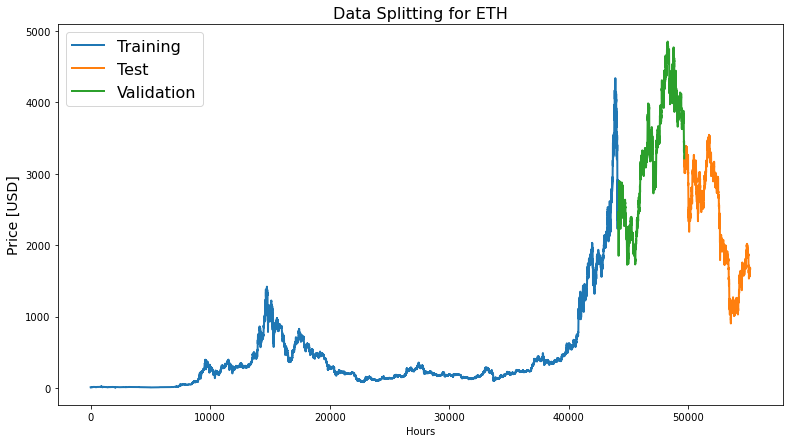

In [11]:
line_plot(train_df['close'], test_df['close'], validation_df['close'], 'Training', 'Test','Validation', title='Data Splitting for ETH')

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [13]:
x = train_[:,3].copy()
scale_close.fit(x.reshape(-1, 1))

MinMaxScaler()

In [14]:
scaler.fit(train_)

train_ = scaler.transform(train_)

valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

In [15]:
# Now perform exponential moving average smoothing for smooth curve of data
EMA = 0.0
gamma = 0.165
for ti in range(train_.shape[0]):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

In [16]:
#data splitting

def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [17]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)


In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

In [19]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

train shape (44000, 120, 6)
valid shape (5387, 120, 6)
test shape (5387, 120, 6)


In [20]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 6))

In [21]:
#LSTM model

import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, BatchNormalization

# Initialize the RNN
model_LSTM1 = Sequential()
model_LSTM1.add(LSTM(units = 120, input_shape=(120, 6)))
model_LSTM1.add(LeakyReLU(alpha=0.5))
model_LSTM1.add(Dropout(0.5))
model_LSTM1.add(BatchNormalization())
model_LSTM1.add(Dense(1))
model_LSTM1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               60960     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 120)               0         
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 batch_normalization (BatchN  (None, 120)              480       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 61,561
Trainable params: 61,321
Non-trainable params: 240
__________________________________________________

In [22]:
model_LSTM1.compile(optimizer='adam', loss='mean_squared_error', metrics = ('MAPE'))

In [23]:
history_LSTM1 = model_LSTM1.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=10, batch_size=128)

Epoch 1/10
344/344 [==============================] - 142s 402ms/step - loss: 0.0169 - MAPE: 921.6954 - val_loss: 0.3449 - val_MAPE: 73.4296
Epoch 2/10
344/344 [==============================] - 124s 361ms/step - loss: 0.0011 - MAPE: 325.7165 - val_loss: 0.0392 - val_MAPE: 24.6283
Epoch 3/10
344/344 [==============================] - 138s 401ms/step - loss: 7.4407e-04 - MAPE: 281.3085 - val_loss: 6.9553e-04 - val_MAPE: 2.8973
Epoch 4/10
344/344 [==============================] - 129s 374ms/step - loss: 6.6946e-04 - MAPE: 263.4684 - val_loss: 7.1526e-04 - val_MAPE: 2.8622
Epoch 5/10
344/344 [==============================] - 146s 424ms/step - loss: 6.2008e-04 - MAPE: 267.3405 - val_loss: 7.1429e-04 - val_MAPE: 2.8468
Epoch 6/10
344/344 [==============================] - 149s 433ms/step - loss: 5.6802e-04 - MAPE: 259.2557 - val_loss: 0.0027 - val_MAPE: 6.1076
Epoch 7/10
344/344 [==============================] - 187s 542ms/step - loss: 5.6606e-04 - MAPE: 267.8976 - val_loss: 5.6739e-04 -

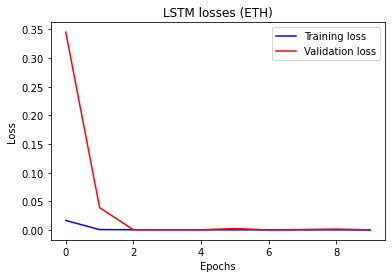

In [24]:
loss = history_LSTM1.history['loss']
val_loss = history_LSTM1.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("LSTM losses (ETH)")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

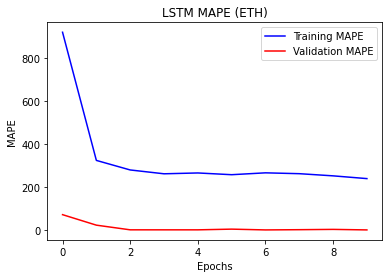

In [25]:
mape = history_LSTM1.history['MAPE']
val_mape = history_LSTM1.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("LSTM MAPE (ETH)")
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

plt.show()

In [26]:
pred_LSTM1 = model_LSTM1.predict(X_test)


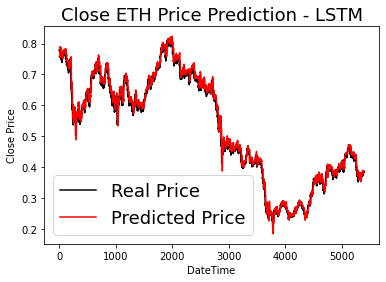

In [27]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_LSTM1, color = 'red', label = 'Predicted Price')
plt.title('Close ETH Price Prediction - LSTM', fontsize=18)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [28]:
import math

LSTM1_loss = model_LSTM1.evaluate(X_test, y_test, verbose=1)

#Err_LSTM1 = LSTM1_loss[0]
#Err_LSTM1 = math.sqrt(LSTM1_loss)
print('\nThe error of the model with 1 layer LSTM is:',LSTM1_loss)

169/169 [==============================] - 10s 60ms/step - loss: 3.3582e-04 - MAPE: 2.8372

The error of the model with 1 layer LSTM is: [0.00033581952448002994, 2.8371975421905518]


In [29]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(pred_LSTM1, y_test)
from sklearn.metrics import r2_score
R2=r2_score(y_test, pred_LSTM1)
print (MAE,R2)

0.00033581950006494974 0.9883902350099257


In [30]:
#GRU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.layers import GRU,CuDNNGRU
model_GRU = Sequential()

model_GRU.add(GRU(units=50, input_shape=(120,6),return_sequences=False))
model_GRU.add(Activation('tanh'))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(1))
model_GRU.add(Activation('relu'))
model_GRU.compile(loss='mse', optimizer='adam', metrics = ('MAPE'))
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8700      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 8,751
Trainable params: 8,751
Non-trainable params: 0
_________________________________________________________________


In [31]:
history_GRU = model_GRU.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 128, epochs = 10)

Epoch 1/10
344/344 [==============================] - 104s 283ms/step - loss: 7.2629e-04 - MAPE: 96.6446 - val_loss: 5.1986e-04 - val_MAPE: 2.3645
Epoch 2/10
344/344 [==============================] - 85s 246ms/step - loss: 2.3429e-04 - MAPE: 53.3069 - val_loss: 5.7282e-04 - val_MAPE: 2.4790
Epoch 3/10
344/344 [==============================] - 82s 239ms/step - loss: 1.8984e-04 - MAPE: 52.5881 - val_loss: 6.7876e-04 - val_MAPE: 2.6756
Epoch 4/10
344/344 [==============================] - 56s 163ms/step - loss: 1.8572e-04 - MAPE: 60.8016 - val_loss: 0.0021 - val_MAPE: 5.1011
Epoch 5/10
344/344 [==============================] - 93s 270ms/step - loss: 1.7343e-04 - MAPE: 67.8515 - val_loss: 5.2493e-04 - val_MAPE: 2.3552
Epoch 6/10
344/344 [==============================] - 98s 286ms/step - loss: 1.7480e-04 - MAPE: 68.7760 - val_loss: 6.5854e-04 - val_MAPE: 2.6496
Epoch 7/10
344/344 [==============================] - 107s 310ms/step - loss: 1.7196e-04 - MAPE: 69.7090 - val_loss: 0.0013 - v

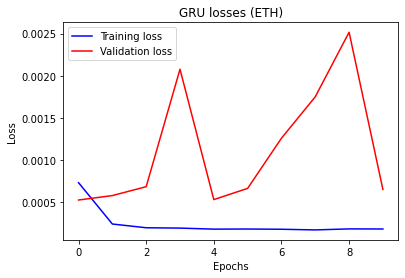

In [32]:
loss_GRU = history_GRU.history['loss']
val_loss_GRU = history_GRU.history['val_loss']

epochs = range(len(loss_GRU))

plt.figure()

plt.plot(epochs, loss_GRU, 'b', label='Training loss')
plt.plot(epochs, val_loss_GRU, 'r', label='Validation loss')
plt.title("GRU losses (ETH)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

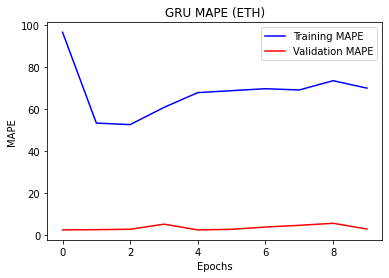

In [33]:
mape = history_GRU.history['MAPE']
val_mape = history_GRU.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("GRU MAPE (ETH)")
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

plt.show()

In [34]:
pred_GRU = model_GRU.predict(X_test)

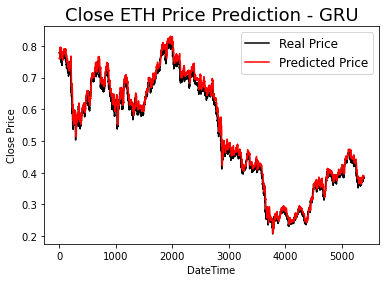

In [35]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_GRU, color = 'red', label = 'Predicted Price')
plt.title('Close ETH Price Prediction - GRU', fontsize=18)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=12)
plt.show()

In [36]:


import math

GRU_loss = model_GRU.evaluate(X_test, y_test, verbose=1)

#Err_GRU = math.sqrt(GRU_loss)
print('\nThe error of the model with a GRU layer is:',GRU_loss)

169/169 [==============================] - 24s 144ms/step - loss: 4.2124e-04 - MAPE: 3.2461

The error of the model with a GRU layer is: [0.00042124080937355757, 3.2461397647857666]


In [37]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(pred_LSTM1, y_test)
from sklearn.metrics import r2_score
R2=r2_score(y_test, pred_LSTM1)
print (MAE,R2)

0.00033581950006494974 0.9883902350099257


In [38]:
#Bi-LSTM
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout, BatchNormalization
from keras.layers import Bidirectional

num_units = 128
activation_function = 'relu'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 128
num_epochs = 10

# Initialize the RNN
regressor2 = Sequential()

# Adding the input layer and the LSTM layer
#regressor2.add(tf.keras.layers.Conv1D(120, 3, activation="relu",input_shape=(120, 5)))
#regressor2.add(tf.keras.layers.AveragePooling1D(4))
regressor2.add(Bidirectional(LSTM(units = num_units, input_shape=(120, 6))))#activation = activation_function,
regressor2.add(LeakyReLU(alpha= 0.5))
regressor2.add(BatchNormalization())
regressor2.add(Dropout(0.5))
# Adding the output layer
regressor2.add(Dense(units = 1))
# Compiling the RNN
regressor2.compile(optimizer = optimizer, loss = loss_function, metrics = ('MAPE'))

In [39]:
# Using the training set to train the model
history_BiLSTM2 = regressor2.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = batch_size, epochs = num_epochs)

Epoch 1/10
344/344 [==============================] - 280s 781ms/step - loss: 0.0438 - MAPE: 1617.9272 - val_loss: 0.3200 - val_MAPE: 70.6601
Epoch 2/10
344/344 [==============================] - 312s 908ms/step - loss: 0.0025 - MAPE: 448.4366 - val_loss: 0.0366 - val_MAPE: 23.7925
Epoch 3/10
344/344 [==============================] - 349s 1s/step - loss: 0.0012 - MAPE: 331.0244 - val_loss: 0.0047 - val_MAPE: 8.5907
Epoch 4/10
344/344 [==============================] - 257s 745ms/step - loss: 8.0677e-04 - MAPE: 264.5254 - val_loss: 0.0023 - val_MAPE: 5.6295
Epoch 5/10
344/344 [==============================] - 198s 577ms/step - loss: 8.3354e-04 - MAPE: 286.5799 - val_loss: 0.0010 - val_MAPE: 3.5156
Epoch 6/10
344/344 [==============================] - 216s 629ms/step - loss: 7.3284e-04 - MAPE: 270.9724 - val_loss: 0.0025 - val_MAPE: 5.2276
Epoch 7/10
344/344 [==============================] - 257s 746ms/step - loss: 6.8807e-04 - MAPE: 274.9383 - val_loss: 0.0051 - val_MAPE: 8.5639
Epoc

In [40]:
regressor2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              138240    
 l)                                                              
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 139,521
Trainable params: 139,009
Non-tr

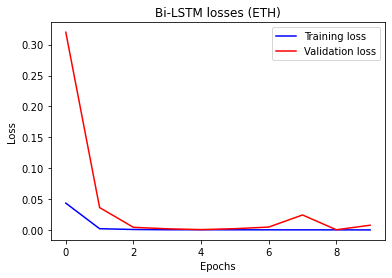

In [41]:
loss_BiLSTM2 = history_BiLSTM2.history['loss']
val_loss_BiLSTM2 = history_BiLSTM2.history['val_loss']

epochs = range(len(loss_BiLSTM2))

plt.figure()

plt.plot(epochs, loss_BiLSTM2, 'b', label='Training loss')
plt.plot(epochs, val_loss_BiLSTM2, 'r', label='Validation loss')
plt.title("Bi-LSTM losses (ETH)")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

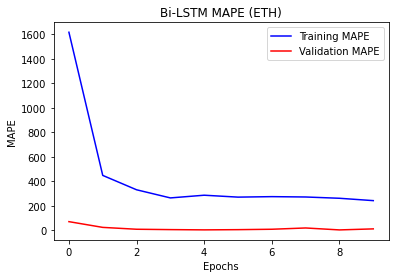

In [42]:
mape = history_BiLSTM2.history['MAPE']
val_mape = history_BiLSTM2.history['val_MAPE']

epochs = range(len(mape))

plt.figure()

plt.plot(epochs, mape, 'b', label='Training MAPE')
plt.plot(epochs, val_mape, 'r', label='Validation MAPE')
plt.title("Bi-LSTM MAPE (ETH)")
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

plt.show()

In [43]:
pred_BiLSTM2 = regressor2.predict(X_test)

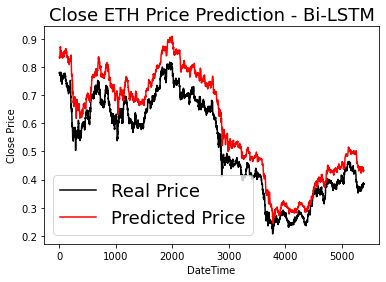

In [44]:
plt.plot(y_test, color = 'black', label = 'Real Price')
plt.plot(pred_BiLSTM2, color = 'red', label = 'Predicted Price')
plt.title('Close ETH Price Prediction - Bi-LSTM', fontsize=18)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()

In [45]:
import math

BiLSTM2_loss = regressor2.evaluate(X_test, y_test, verbose=1)
print('\nThe error of the model with 1 layer BiLSTM is:',BiLSTM2_loss)

169/169 [==============================] - 15s 90ms/step - loss: 0.0060 - MAPE: 14.1623

The error of the model with 1 layer BiLSTM is: [0.00595131004229188, 14.162280082702637]


In [46]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(pred_BiLSTM2, y_test)
from sklearn.metrics import r2_score
R2=r2_score(y_test, pred_BiLSTM2)
print (MAE,R2)

0.005951309826361551 0.7942546265067572
